In [15]:
# Scientific computing imports
import numpy as np
import scipy as sc
import pandas as pd

from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import cohen_kappa_score

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests
# Imports for analysis

# OS imports
from os.path import join as ospj
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
plt.rcParams['image.cmap'] = 'magma'

In [16]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2

plt.rcParams['xtick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['ytick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['xtick.minor.size'] = 3   # Change to your desired minor tick size
plt.rcParams['ytick.minor.size'] = 3   # Change to your desired minor tick size

plt.rcParams['xtick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['ytick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['xtick.minor.width'] = 1  # Change to your desired minor tick width
plt.rcParams['ytick.minor.width'] = 1  # Change to your desired minor tick width

In [17]:
def wideform_preds(element,all_labels):
    return [label in element for label in all_labels]

def shortform_preds(element,all_labels):
    a = np.array(all_labels)[element]
    return a
def apply_dice_score(row):
    all_chs = row.all_chs
    for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
        row[col+'_chs'] = shortform_preds(row[col],all_chs)
        for pred in ['strict','loose']:
            ch_preds = row[f'{col[:3]}_chs_{pred}']
            if (len(ch_preds) + len(row[col+'_chs'])) == 0:
                row[f'{col}_{pred}_dice'] = 0
            else:
                row[f'{col}_{pred}_dice'] = dice_score(row[col+'_chs'],ch_preds)
    return row

def apply_kappa_score(row):
    all_chs = row.all_chs
    for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
        # need to turn model predictions into the wideform
        row[col+'_bool'] = wideform_preds(row[col],all_chs)
        for annot in ['consensus','any']:
            ch_preds = row[f'{col[:3]}_{annot}']
            # if (sum(ch_preds) + sum(row[col+'_bool'])) == 0:
            #     row[f'{col}_{annot}_kappa'] = 0
            # else:
            row[f'{col}_{annot}_kappa'] = cohen_kappa_score(row[col+'_bool'],ch_preds)
    return row

def apply_specificity(row):
    all_chs = row.all_chs
    for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
        # need to turn model predictions into the wideform
        row[col+'_bool'] = np.atleast_1d(wideform_preds(row[col],all_chs))
        for annot in ['consensus','any']:
            ch_preds = row[f'{col[:3]}_{annot}']
            # if (sum(ch_preds) + sum(row[col+'_bool'])) == 0:
            #     row[f'{col}_{annot}_kappa'] = 0
            # else:
            row[f'{col}_{annot}_spec'] = recall_score(row[col+'_bool']==False,ch_preds==False)
    return row

## Config

In [5]:
usr,passpath,datapath,prodatapath,metapath,figpath,patient_table,rid_hup,pt_list = load_config(ospj('/mnt/leif/littlab/users/wojemann/stim-seizures/code','config.json'))

In [6]:
patient_table

,ptID,ieeg_ids,lf_stim,hf_stim,typical,mtle,focality,laterality,interictal_training
13,HUP224,"[HUP224_phaseII, HUP224_CCEP]",1,0,0.0,1.0,1.0,2.0,"[HUP224_phaseII, 5915]"
14,HUP225,"[HUP225_phaseII, HUP225_CCEP]",1,0,1.0,0.0,0.0,1.0,"[HUP225_phaseII, 71207]"
15,HUP229,"[HUP229_phaseII, HUP229_CCEP]",1,0,1.0,1.0,0.0,0.0,"[HUP229_phaseII, 149146]"
16,HUP230,"[HUP230_phaseII, HUP230_CCEP]",1,0,1.0,1.0,0.0,0.0,"[HUP230_phaseII, 25350]"
17,HUP235,"[HUP235_phaseII, HUP235_CCEP]",1,1,1.0,1.0,0.0,0.0,"[HUP235_phaseII, 307651]"
18,HUP238,"[HUP238_phaseII, HUP238_CCEP]",1,0,1.0,1.0,0.0,0.0,"[HUP238_phaseII, 100011]"
19,HUP246,"[HUP246_phaseII, HUP246_CCEP]",1,0,1.0,1.0,0.0,0.0,"[HUP246_phaseII, 100000]"
20,HUP247,"[HUP247_phaseII, HUP247_CCEP]",1,0,1.0,0.0,0.0,1.0,"[HUP247_phaseII, 17590]"
21,HUP249,"[HUP249_phaseII, HUP249_CCEP]",1,0,0.0,0.0,1.0,2.0,"[HUP249_phaseII, 24112]"
22,HUP250,"[HUP250_phaseII, HUP250_CCEP]",1,0,1.0,0.0,2.0,3.0,"[HUP250_phaseII, 24841]"


## Formatting Model Predictions

### Channel level

In [6]:
# # Loading in human annotations with consensus annotation already created
# annotations_df = pd.read_pickle(ospj(prodatapath,"threshold_tuning_consensus.pkl"))
# annotations_df.columns = ['Patient' if c == 'patient' else c for c in annotations_df.columns]

# # Loading in predicted channels for all models from generate_model_annotations.py
# predicted_channels = pd.read_pickle(ospj(prodatapath,"pretrain_predicted_channels_nor.pkl"))
# predicted_channels = predicted_channels[predicted_channels.to_annotate == 1]

# # Sorting
# predicted_channels.sort_values('approximate_onset',inplace=True)
# # predicted_channels = predicted_channels[predicted_channels.stim == 0]
# annotations_df.sort_values('approximate_onset',inplace=True)

# # Creating a merged table with human and machine annotations based on approximate seizure onset time
# pred_channels_wannots = pd.merge_asof(predicted_channels,
#                                     annotations_df[['approximate_onset','Patient','all_chs','ueo_consensus','ueo_any','sec_consensus','sec_any']],
#                                     on='approximate_onset',by='Patient',
#                                     tolerance = 240,
#                                     direction='nearest')
# pred_channels_wannots.dropna(axis=0,subset='ueo_consensus',inplace=True)
# pred_channels_wannots.sort_values(['Patient','iEEG_ID','approximate_onset'],inplace=True)
# pred_channels_wdice = pred_channels_wannots.apply(apply_dice_score,axis=1)
# # pred_channels_wkappa = pred_channels_wannots.apply(apply_kappa_score,axis=1)
# # # pred_channels_wspec = pred_channels_wannots.apply(apply_specificity,axis=1)

In [7]:
# # pred_channels_wspec.to_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wspec.pkl"))
# pred_channels_wdice.to_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wdice_nor.pkl"))
# # pred_channels_wkappa.to_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wkappa_nor.pkl"))

## Channel Agreement Optimization

### Calculating clinician consensus


In [8]:
consensus_annots = pd.read_pickle(ospj(prodatapath,'threshold_tuning_consensus.pkl'))
consensus_annots.head()
# spread_consensus_annots = consensus_annots.copy()
# for i_r, row in consensus_annots.iterrows():
#     annot_sets = row.ueo
#     die = 0
#     for annot in annot_sets:
#         die += f1_score(annot,row.ueo_consensus)
#     consensus_annots.loc[i_r,'f1'] = die/len(annot_sets)
# for i_r, row in spread_consensus_annots.iterrows():
#     annot_sets = row.sec
#     die = 0
#     for annot in annot_sets:
#         die += f1_score(annot,row.sec_consensus)
#     spread_consensus_annots.loc[i_r,'f1'] = die/len(annot_sets)

,Seizure_ID,clinician,patient,ueo,ueo_time,sec,all_chs,iEEG_ID,approximate_onset,offset,stim,ueo_consensus,ueo_any,ueo_time_consensus,sec_consensus,sec_any
0,CHOP005_1,"[CK, JJ, JK]",CHOP005,"[[False, False, False, False, False, False, Fa...","[68881.44, 68881.52, 68881.26]","[[False, False, False, False, False, False, Fa...","[LA01, LA10, LA02, LA03, LA04, LA05, LA06, LA0...",CHOP005,68881.53,68944.57,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",68881.44,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."
1,CHOP010_1,"[DZ, EC, JK]",CHOP010,"[[False, False, False, False, False, False, Fa...","[2232.773277, 2232.6, 2232.77]","[[False, False, False, False, False, False, Fa...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",CHOPCCEP_010,2230.26,2267.78,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",2232.77,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."
2,CHOP015_1,"[CK, JJ, JK]",CHOP015,"[[False, False, False, False, False, False, Fa...","[77180.36, 77180.95, 77190.4]","[[False, False, False, False, False, False, Fa...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",CHOPCCEP_015,77190.79,77225.07,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",77180.95,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."
3,CHOP015_2,"[CK, JJ, JK]",CHOP015,"[[False, False, False, False, False, False, Fa...","[81584.13, 81587.68, 81587.23]","[[False, False, False, True, True, False, Fals...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",CHOPCCEP_015,81585.72,81614.99,0.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",81587.23,"[False, False, False, True, True, False, False...","[False, False, True, True, True, True, False, ..."
4,CHOP024_1,"[CK, DZ, JJ]",CHOP024,"[[False, False, False, False, False, False, Fa...","[87577.58, 875775.9034, 87576.74]","[[False, False, False, False, False, False, Fa...","[LA01, LA10, LA02, LA03, LA04, LA05, LA06, LA0...",CHOPCCEP_024,87579.25,87591.61,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",87577.58,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."


In [9]:
consensus_annots = consensus_annots[consensus_annots.stim == 0]
consensus_annots = consensus_annots[consensus_annots.clinician.apply(lambda x: len(x)>1)]
spread_consensus_annots = consensus_annots.copy()
note_type = 'ueo'
for i_r, row in consensus_annots.iterrows():
    scores = 0
    annots = row[note_type]
    for i_annot in range(len(annots)):
        for j_annot in range(i_annot+1,len(annots)):
            scores += f1_score(annots[i_annot],annots[j_annot])
    consensus_annots.loc[i_r,'f1'] = scores/(len(annots)*(len(annots)-1)/2)
consensus_annots["model"] = ["Clin."]*len(consensus_annots)
consensus_annots["dice"] = consensus_annots["f1"]


note_type = 'sec'
for i_r, row in spread_consensus_annots.iterrows():
    scores = 0
    annots = row[note_type]
    for i_annot in range(len(annots)):
        for j_annot in range(i_annot+1,len(annots)):
            scores += f1_score(annots[i_annot],annots[j_annot])
    spread_consensus_annots.loc[i_r,'f1'] = scores/(len(annots)*(len(annots)-1)/2)


### Data Prep

In [10]:
anntype='consensus'
mdl_anntype = 'loose'
montage = 'bipolar'
mdl_preds = pd.read_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wdice_nor.pkl"))

In [11]:
mdl_preds = mdl_preds[mdl_preds.stim == 0]

In [12]:
mdl_preds_sorted = mdl_preds.sort_values(['Patient','approximate_onset','threshold','model'])

In [13]:
melt_cols = [f'ueo_{anntype}_{mdl_anntype}_dice',f'sec_{anntype}_{mdl_anntype}_dice']
keep_cols = [c for c in mdl_preds_sorted.columns if c not in melt_cols]
mdl_preds_long = mdl_preds_sorted.melt(id_vars=keep_cols,var_name='annot',value_name='dice')
mdl_preds_long.Patient.unique()

array(['CHOP041', 'CHOP049', 'HUP224', 'HUP225', 'HUP229', 'HUP230',
       'HUP235', 'HUP238', 'HUP246', 'HUP247', 'HUP249', 'HUP250',
       'HUP253', 'HUP257', 'HUP261', 'HUP263', 'HUP266', 'HUP267',
       'HUP273', 'HUP275', 'HUP288'], dtype=object)

In [14]:
tune_preds_long = mdl_preds_long[mdl_preds_long.annot == 'ueo_consensus_loose_dice']
val_preds_long = mdl_preds_long[mdl_preds_long.annot == 'sec_consensus_loose_dice']

### Threshold sweeping

In [15]:
# fig,axs = plt.subplots(1,2)
# sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'ueo_{anntype}_{mdl_anntype}_dice'],x='threshold',y='dice',hue='model',ax=axs[0])
# axs[0].set_ylim((-.1,.7))
# axs[0].set_title('Onset Annots')
# sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'sec_{anntype}_{mdl_anntype}_dice'],x='threshold',y='dice',hue='model',ax=axs[1],legend=False)
# axs[1].set_ylim((-.1,.7))
# axs[1].set_yticks([])
# axs[1].set_ylabel('')
# axs[1].set_title('Spread Annots')
# fig.suptitle(f'Model Annotator Agreement - {anntype}')
# fig.savefig(ospj(figpath,f'ueo_ch_dice_{anntype}-{mdl_anntype}.pdf'),transparent=True)

In [16]:
# fig,ax = plt.subplots()
# ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_{anntype}_{mdl_anntype}_dice') & (mdl_preds_long.model == 'WVNT')],x='threshold',y='dice',hue='Patient',errorbar=None,legend=True)
# fig.savefig(ospj(figpath,f'pt_WVNT_ueo_ch_dice_{anntype}-{mdl_anntype}.pdf'),transparent=True)

In [17]:
# ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_{anntype}_{mdl_anntype}_dice') & (mdl_preds_long.model == 'LSTM')],x='threshold',y='dice',hue='Patient',errorbar=None,)

### Tuning at the seizure level

#### Tuning and testing on onset

In [18]:
optimal_threshold_preds = tune_preds_long.loc[tune_preds_long.groupby(['Patient', 'approximate_onset','model'])['dice'].idxmax()][["model","dice","Patient","stim","approximate_onset",'threshold']]

In [19]:
consensus_annots["model"] = ["Clin."]*len(consensus_annots)
consensus_annots["dice"] = consensus_annots["f1"]
all_plot_agreements = pd.concat([optimal_threshold_preds,consensus_annots[["model","dice"]]])

In [20]:
for mdl in optimal_threshold_preds.model.unique():
    print(mdl)
    print(sc.stats.mannwhitneyu(consensus_annots.f1,optimal_threshold_preds[optimal_threshold_preds.model == mdl].dice))

AbsSlp
MannwhitneyuResult(statistic=1338.5, pvalue=1.1810183001145381e-05)
LSTM
MannwhitneyuResult(statistic=983.0, pvalue=0.2556477641864684)
NRG
MannwhitneyuResult(statistic=1210.0, pvalue=0.0013315481427134807)
WVNT
MannwhitneyuResult(statistic=1097.5, pvalue=0.029072308596296413)


Text(0.5, 1.0, 'Onset Tuned Onset Detection')

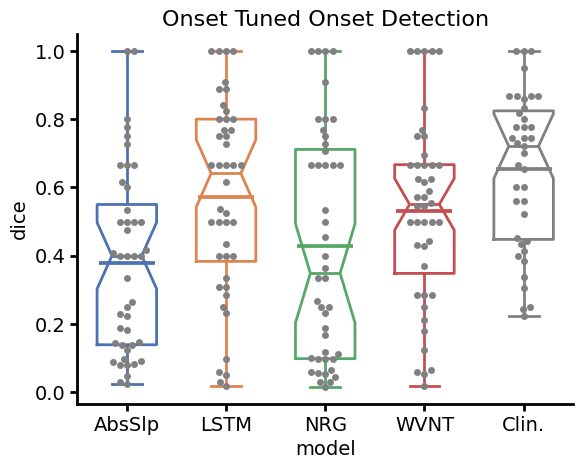

In [22]:
colors = sns.color_palette("deep", 4)
bx = sns.boxplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
                 order=['AbsSlp','LSTM','NRG','WVNT','Clin.'],width=.6,notch=True,fill=False)
sns.swarmplot(all_plot_agreements,x='model',y='dice',color='gray')
sns.pointplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              order = ['AbsSlp','LSTM','NRG','WVNT','Clin.'],marker='_',markersize=40,errorbar=None)
sns.despine()
plt.title("Onset Tuned Onset Detection")

In [23]:
all_ps = []
for i_mdl in optimal_threshold_preds.model.unique():
    for j_mdl in optimal_threshold_preds.model.unique():
        print(i_mdl,j_mdl)
        p = sc.stats.mannwhitneyu(optimal_threshold_preds[optimal_threshold_preds.model == i_mdl]['dice'],optimal_threshold_preds[optimal_threshold_preds.model == j_mdl]['dice'])
        d=cohens_d(optimal_threshold_preds[optimal_threshold_preds.model == i_mdl]['dice'],
                 optimal_threshold_preds[optimal_threshold_preds.model == j_mdl]['dice'])
        print(d)
        all_ps.append(p)
        print(p)

AbsSlp AbsSlp
0.0
MannwhitneyuResult(statistic=968.0, pvalue=1.0)
AbsSlp LSTM
-0.6896818971587432
MannwhitneyuResult(statistic=601.0, pvalue=0.002195962478291771)
AbsSlp NRG
-0.16207330706189582
MannwhitneyuResult(statistic=912.0, pvalue=0.6429767199323903)
AbsSlp WVNT
-0.5621701137705875
MannwhitneyuResult(statistic=658.0, pvalue=0.009706540554075022)
LSTM AbsSlp
0.6896818971587432
MannwhitneyuResult(statistic=1335.0, pvalue=0.002195962478291771)
LSTM LSTM
0.0
MannwhitneyuResult(statistic=968.0, pvalue=1.0)
LSTM NRG
0.4612565823160101
MannwhitneyuResult(statistic=1213.0, pvalue=0.04100556265719371)
LSTM WVNT
0.1446493208250358
MannwhitneyuResult(statistic=1067.0, pvalue=0.4101523479398559)
NRG AbsSlp
0.16207330706189582
MannwhitneyuResult(statistic=1024.0, pvalue=0.6429767199323903)
NRG LSTM
-0.4612565823160101
MannwhitneyuResult(statistic=723.0, pvalue=0.04100556265719371)
NRG NRG
0.0
MannwhitneyuResult(statistic=968.0, pvalue=1.0)
NRG WVNT
-0.3396647834305886
MannwhitneyuResult(stat

#### Testing on spread

In [24]:
val_tuned_thresholds = val_preds_long[['Patient','approximate_onset','model','threshold','dice']].merge(optimal_threshold_preds[['Patient','approximate_onset','model','threshold']],on=['Patient','approximate_onset','model','threshold'],how='inner')

In [25]:
spread_consensus_annots["model"] = ["Clin."]*len(spread_consensus_annots)
spread_consensus_annots["dice"] = spread_consensus_annots["f1"]
spread_plot_agreements = pd.concat([val_tuned_thresholds,spread_consensus_annots[["model","dice"]]])

In [26]:
all_ps = []
for mdl in val_tuned_thresholds.model.unique():
    print(mdl)
    p = sc.stats.mannwhitneyu(spread_consensus_annots.f1,val_tuned_thresholds[val_tuned_thresholds.model == mdl].dice)
    print(p)
    all_ps.append(p[1])
multipletests(all_ps)

NRG
MannwhitneyuResult(statistic=1220.0, pvalue=0.0009721459159004025)
LSTM
MannwhitneyuResult(statistic=1188.5, pvalue=0.002602664448917946)
AbsSlp
MannwhitneyuResult(statistic=1371.5, pvalue=2.85742388609099e-06)
WVNT
MannwhitneyuResult(statistic=1326.5, pvalue=1.9510942578404876e-05)


(array([ True,  True,  True,  True]),
 array([1.94334676e-03, 2.60266445e-03, 1.14296466e-05, 5.85316857e-05]),
 0.012741455098566168,
 0.0125)

Text(0.5, 1.0, 'Seizure Annotation Generalization to Spread')

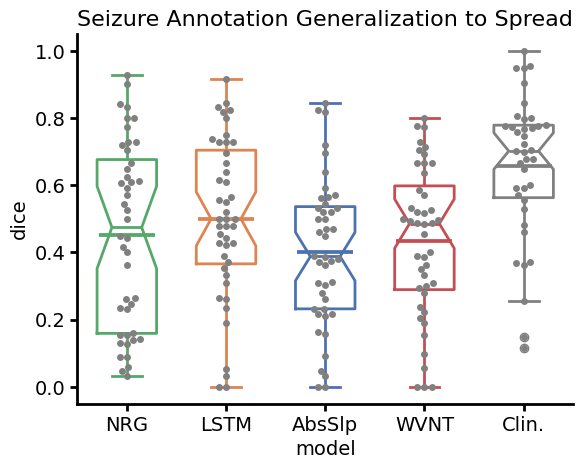

In [27]:
colors = sns.color_palette("deep", 4)
sns.swarmplot(spread_plot_agreements,x='model',y='dice',color='gray')
sns.pointplot(spread_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              order = ['AbsSlp','LSTM','NRG','WVNT','Clin.'],marker='_',markersize=40,errorbar=None)
sns.boxplot(spread_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
                 order=['AbsSlp','LSTM','NRG','WVNT','Clin.'],width=.6,notch=True,fill=False)
sns.despine()
plt.title("Seizure Annotation Generalization to Spread")

In [28]:
all_ps = []
for i_mdl in optimal_threshold_preds.model.unique():
    for j_mdl in optimal_threshold_preds.model.unique():
        print(i_mdl,j_mdl)
        p = sc.stats.mannwhitneyu(val_tuned_thresholds[val_tuned_thresholds.model == i_mdl]['dice'],val_tuned_thresholds[val_tuned_thresholds.model == j_mdl]['dice'])
        d=cohens_d(val_tuned_thresholds[val_tuned_thresholds.model == i_mdl]['dice'],
                 val_tuned_thresholds[val_tuned_thresholds.model == j_mdl]['dice'])
        print(d)
        all_ps.append(p)
        print(p)

AbsSlp AbsSlp
0.0
MannwhitneyuResult(statistic=968.0, pvalue=1.0)
AbsSlp LSTM
-0.4340710285124916
MannwhitneyuResult(statistic=723.5, pvalue=0.041683085992610475)
AbsSlp NRG
-0.20430053519384292
MannwhitneyuResult(statistic=856.5, pvalue=0.35423403422417543)
AbsSlp WVNT
-0.14249206379613913
MannwhitneyuResult(statistic=886.5, pvalue=0.49898355696764807)
LSTM AbsSlp
0.4340710285124916
MannwhitneyuResult(statistic=1212.5, pvalue=0.041683085992610475)
LSTM LSTM
0.0
MannwhitneyuResult(statistic=968.0, pvalue=1.0)
LSTM NRG
0.1885322515713122
MannwhitneyuResult(statistic=1062.5, pvalue=0.43267906523846467)
LSTM WVNT
0.2920230156314071
MannwhitneyuResult(statistic=1129.5, pvalue=0.1789698344856474)
NRG AbsSlp
0.20430053519384292
MannwhitneyuResult(statistic=1079.5, pvalue=0.35423403422417543)
NRG LSTM
-0.1885322515713122
MannwhitneyuResult(statistic=873.5, pvalue=0.43267906523846467)
NRG NRG
0.0
MannwhitneyuResult(statistic=968.0, pvalue=1.0)
NRG WVNT
0.07621390009735093
MannwhitneyuResult(st

### Tuning at the patient level

In [29]:
# Group by 'Patient', 'model', and 'threshold' to calculate the average dice score for each threshold
avg_dice_per_threshold = tune_preds_long.groupby(['Patient', 'model', 'threshold','annot'])['dice'].mean().reset_index()

# Now, for each 'Patient' and 'model', find the threshold that maximizes the average dice score
threshold_list = avg_dice_per_threshold.loc[avg_dice_per_threshold.groupby(['Patient', 'model','annot'])['dice'].idxmax()]

# The result will contain the patient, model, threshold, and the average dice score
threshold_list = threshold_list[['Patient', 'model', 'threshold', 'dice']].reset_index(drop=True)

In [30]:
threshold_list.to_pickle(ospj(prodatapath,'patient_tuned_classification_thresholds'))

In [31]:
val_tuned_thresholds = val_preds_long[['Patient','model','threshold','dice']].merge(threshold_list[['Patient','model','threshold']],on=['Patient','model','threshold'],how='inner')
tuned_thresholds = tune_preds_long[['Patient','model','threshold','dice']].merge(threshold_list[['Patient','model','threshold']],on=['Patient','model','threshold'],how='inner')

#### Onset

In [32]:
all_plot_agreements = pd.concat([tuned_thresholds,consensus_annots[["model","dice"]]])

In [49]:
for mdl in tuned_thresholds.model.unique():
    print(mdl)
    print(sc.stats.mannwhitneyu(consensus_annots.f1,tuned_thresholds[tuned_thresholds.model == mdl].dice))
    print(cohens_d(consensus_annots.f1,tuned_thresholds[tuned_thresholds.model == mdl].dice))

NRG
MannwhitneyuResult(statistic=1403.5, pvalue=6.405624459416351e-07)
1.3082692076561035
LSTM
MannwhitneyuResult(statistic=1198.0, pvalue=0.0019380294135511319)
0.7705222795488766
AbsSlp
MannwhitneyuResult(statistic=1458.5, pvalue=4.324810816141123e-08)
1.5150045391059637
WVNT
MannwhitneyuResult(statistic=1218.5, pvalue=0.0010128369586936466)
0.7735748318835459


Text(0.5, 1.0, 'Patient-level Optimal Onset Threshold')

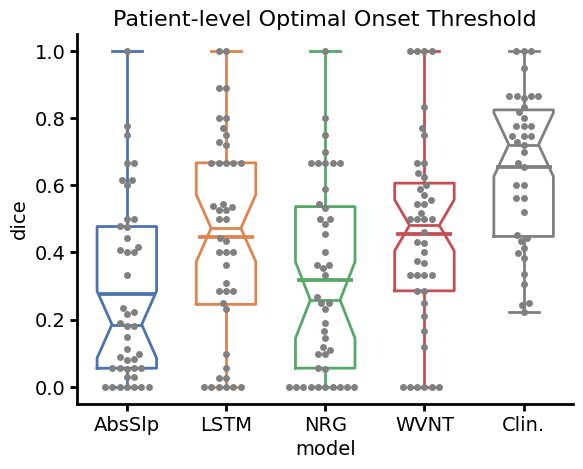

In [34]:
colors = sns.color_palette("deep", 4)
bx = sns.boxplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
                 order=['AbsSlp','LSTM','NRG','WVNT','Clin.'],width=.6,notch=True,fill=False)
sns.swarmplot(all_plot_agreements,x='model',y='dice',color='gray')
sns.pointplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              order = ['AbsSlp','LSTM','NRG','WVNT','Clin.'],marker='_',markersize=40,errorbar=None)
sns.despine()
plt.title("Patient-level Optimal Onset Threshold")

In [35]:
all_ps = []
for i_mdl in tuned_thresholds.model.unique():
    for j_mdl in tuned_thresholds.model.unique():
        print(i_mdl,j_mdl)
        p = sc.stats.mannwhitneyu(tuned_thresholds[tuned_thresholds.model == i_mdl]['dice'],tuned_thresholds[tuned_thresholds.model == j_mdl]['dice'])
        d=cohens_d(tuned_thresholds[tuned_thresholds.model == i_mdl]['dice'],
                 tuned_thresholds[tuned_thresholds.model == j_mdl]['dice'])
        print(d)
        all_ps.append(p)
        print(p)

NRG NRG
0.0
MannwhitneyuResult(statistic=968.0, pvalue=1.0)
NRG LSTM
-0.43823779231818244
MannwhitneyuResult(statistic=728.5, pvalue=0.045242475726482566)
NRG AbsSlp
0.15140230191600412
MannwhitneyuResult(statistic=1042.5, pvalue=0.5352549471459676)
NRG WVNT
-0.48131778583225376
MannwhitneyuResult(statistic=720.5, pvalue=0.038561922027798734)
LSTM NRG
0.43823779231818244
MannwhitneyuResult(statistic=1207.5, pvalue=0.045242475726482566)
LSTM LSTM
0.0
MannwhitneyuResult(statistic=968.0, pvalue=1.0)
LSTM AbsSlp
0.5931495987658768
MannwhitneyuResult(statistic=1266.0, pvalue=0.012851287608418999)
LSTM WVNT
-0.0268355042283785
MannwhitneyuResult(statistic=975.0, pvalue=0.956652131394318)
AbsSlp NRG
-0.15140230191600412
MannwhitneyuResult(statistic=893.5, pvalue=0.5352549471459676)
AbsSlp LSTM
-0.5931495987658768
MannwhitneyuResult(statistic=670.0, pvalue=0.012851287608418999)
AbsSlp AbsSlp
0.0
MannwhitneyuResult(statistic=968.0, pvalue=1.0)
AbsSlp WVNT
-0.6432252935294525
MannwhitneyuResult(

#### Spread

In [36]:
all_plot_agreements = pd.concat([val_tuned_thresholds,spread_consensus_annots[["model","dice"]]])

In [37]:
for mdl in val_tuned_thresholds.model.unique():
    print(mdl)
    print(sc.stats.mannwhitneyu(spread_consensus_annots.f1,val_tuned_thresholds[val_tuned_thresholds.model == mdl].dice))

NRG
MannwhitneyuResult(statistic=1258.0, pvalue=0.0002667741636498348)
LSTM
MannwhitneyuResult(statistic=1304.0, pvalue=4.7887633415445655e-05)
AbsSlp
MannwhitneyuResult(statistic=1414.0, pvalue=3.996952095685909e-07)
WVNT
MannwhitneyuResult(statistic=1296.5, pvalue=6.425096959549981e-05)


Text(0.5, 1.0, 'Patient-level Optimal Onset Thresholds Detecting Spread')

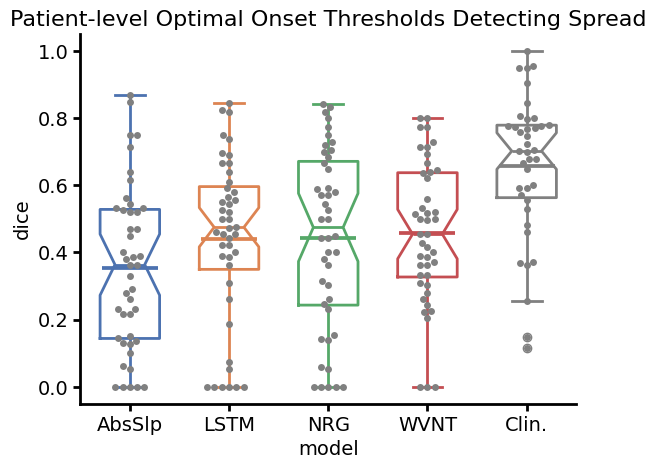

In [38]:
colors = sns.color_palette("deep", 4)
bx = sns.boxplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
                 order=['AbsSlp','LSTM','NRG','WVNT','Clin.'],width=.6,notch=True,fill=False)
sns.swarmplot(all_plot_agreements,x='model',y='dice',color='gray')
sns.pointplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              order = ['AbsSlp','LSTM','NRG','WVNT','Clin.'],marker='_',markersize=40,errorbar=None)
sns.despine()
plt.title("Patient-level Optimal Onset Thresholds Detecting Spread")

## KDE Model Predictions

In [7]:
# Loading in human annotations with consensus annotation already created
annotations_df = pd.read_pickle(ospj(prodatapath,"threshold_tuning_consensus.pkl"))
annotations_df.columns = ['Patient' if c == 'patient' else c for c in annotations_df.columns]

# Loading in predicted channels for all models from generate_model_annotations.py
predicted_channels = pd.read_pickle(ospj(prodatapath,"kdeknee_predicted_channels_nor.pkl"))
# predicted_channels = pd.read_pickle(ospj(prodatapath,"gamma_predicted_channels_nor.pkl"))
predicted_channels = predicted_channels[predicted_channels.to_annotate == 1]

# Sorting
predicted_channels.sort_values('approximate_onset',inplace=True)
predicted_channels = predicted_channels[(predicted_channels.stim == 0) & predicted_channels.Patient.apply(lambda x: 'HUP' in x)]
annotations_df.sort_values('approximate_onset',inplace=True)

# Creating a merged table with human and machine annotations based on approximate seizure onset time
pred_channels_wannots = pd.merge_asof(predicted_channels,
                                    annotations_df[['approximate_onset','Patient','all_chs','ueo_consensus','ueo_any','sec_consensus','sec_any']],
                                    on='approximate_onset',by='Patient',
                                    tolerance = 240,
                                    direction='nearest')
pred_channels_wannots.dropna(axis=0,subset='ueo_consensus',inplace=True)
pred_channels_wannots.sort_values(['Patient','iEEG_ID','approximate_onset'],inplace=True)
pred_channels_wdice = pred_channels_wannots.apply(apply_dice_score,axis=1)
pred_channels_wkappa = pred_channels_wannots.apply(apply_kappa_score,axis=1)

In [8]:
predicted_channels.Patient.unique()

array(['HUP247', 'HUP253', 'HUP235', 'HUP249', 'HUP250', 'HUP263',
       'HUP230', 'HUP266', 'HUP238', 'HUP225', 'HUP224', 'HUP257',
       'HUP229', 'HUP246'], dtype=object)

In [9]:
# pred_channels_wdice = pred_channels_wdice[pred_channels_wdice.ueo_consensus_strict_dice > 0]

In [10]:
pred_channels_wdice[pred_channels_wdice.Patient == 'HUP275']

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,ueo_consensus_loose_dice,ueo_any_chs,ueo_any_strict_dice,ueo_any_loose_dice,sec_consensus_chs,sec_consensus_strict_dice,sec_consensus_loose_dice,sec_any_chs,sec_any_strict_dice,sec_any_loose_dice


In [11]:
pred_type = 'ueo_any_strict_dice'

Text(0.5, 1.0, 'KDE Unsupervised Onset Annotation')

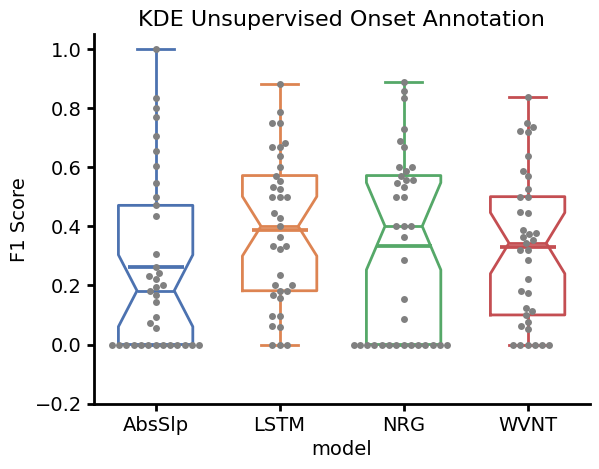

In [12]:
bx = sns.boxplot(pred_channels_wdice,x='model',y=pred_type,palette='deep',order=['AbsSlp','LSTM','NRG','WVNT'],width=.6,notch=True,fill=False)
sns.swarmplot(pred_channels_wdice,x='model',y=pred_type,color='gray')
sns.pointplot(pred_channels_wdice,x='model',y=pred_type,palette='deep',order = ['AbsSlp','LSTM','NRG','WVNT'],marker='_',markersize=40,errorbar=None)
sns.despine()
plt.ylabel('F1 Score')
plt.ylim([-.2,1.05])
plt.title("KDE Unsupervised Onset Annotation")

Text(0.5, 1.0, 'KDE Unsupervised Annotation')

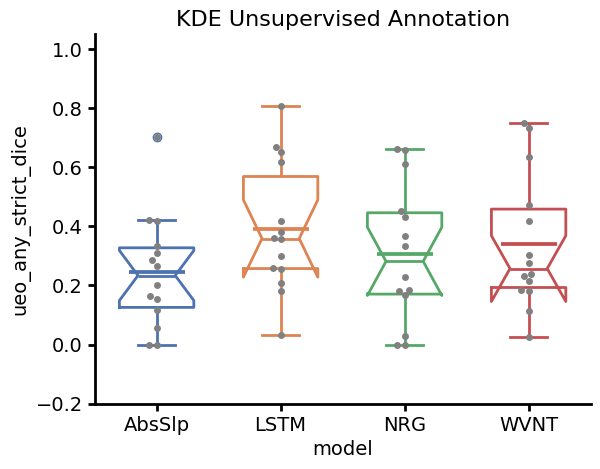

In [18]:
pt_pred_channels_wdice = pred_channels_wdice.groupby(['Patient','model'])[[pred_type]].mean().reset_index()
bx = sns.boxplot(pt_pred_channels_wdice,x='model',y=pred_type,palette='deep',order=['AbsSlp','LSTM','NRG','WVNT'],width=.6,notch=True,fill=False)
sns.swarmplot(pt_pred_channels_wdice,x='model',y=pred_type,color='gray')
sns.pointplot(pt_pred_channels_wdice,x='model',y=pred_type,palette='deep',order = ['AbsSlp','LSTM','NRG','WVNT'],marker='_',markersize=40,errorbar=None)
sns.despine()
plt.ylim([-.2,1.05])
plt.title("KDE Unsupervised Annotation")

In [14]:
all_ps = []
for i_mdl in pred_channels_wdice.model.unique():
    for j_mdl in pred_channels_wdice.model.unique():
        print(i_mdl,j_mdl)
        p = sc.stats.mannwhitneyu(pred_channels_wdice[pred_channels_wdice.model == i_mdl][pred_type],pred_channels_wdice[pred_channels_wdice.model == j_mdl][pred_type])
        d=cohens_d(pred_channels_wdice[pred_channels_wdice.model == i_mdl][pred_type],
                 pred_channels_wdice[pred_channels_wdice.model == j_mdl][pred_type])
        print(d)
        all_ps.append(p)
        print(p)

WVNT WVNT
0.0
MannwhitneyuResult(statistic=684.5, pvalue=1.0)
WVNT NRG
-0.008072513655182818
MannwhitneyuResult(statistic=698.0, pvalue=0.8871053443430228)
WVNT AbsSlp
0.24752463107654618
MannwhitneyuResult(statistic=819.0, pvalue=0.14398491704671776)
WVNT LSTM
-0.2291073943750663
MannwhitneyuResult(statistic=587.0, pvalue=0.29377078141369706)
NRG WVNT
0.008072513655182818
MannwhitneyuResult(statistic=671.0, pvalue=0.8871053443430228)
NRG NRG
0.0
MannwhitneyuResult(statistic=684.5, pvalue=1.0)
NRG AbsSlp
0.2339718276445783
MannwhitneyuResult(statistic=752.0, pvalue=0.45770545965693343)
NRG LSTM
-0.1983619897140556
MannwhitneyuResult(statistic=589.0, pvalue=0.3012981567537514)
AbsSlp WVNT
-0.24752463107654618
MannwhitneyuResult(statistic=550.0, pvalue=0.14398491704671776)
AbsSlp NRG
-0.2339718276445783
MannwhitneyuResult(statistic=617.0, pvalue=0.45770545965693343)
AbsSlp AbsSlp
0.0
MannwhitneyuResult(statistic=684.5, pvalue=1.0)
AbsSlp LSTM
-0.4597592692846071
MannwhitneyuResult(statis

## Alternate Annotations

In [25]:
alt_annots = pd.read_csv(ospj(metapath,'Results_Raw_FINAL.csv'))

In [26]:
alt_onset_annots_1k = alt_annots[(alt_annots['Cutoff Frequency'] == 1000) & (alt_annots['Symbol Number'] == str(1))]
grouped_annots = alt_onset_annots_1k.groupby(['Marker','Patient File']).apply(lambda x: [y['Channel Marked'] for _,y in x.iterrows()]).reset_index()

In [27]:
all_dice = []
for i_g, group in grouped_annots.groupby('Patient File'):
    if len(group) <= 1:
        continue
    dice_val = 0
    for i_annot in range(len(group)):
        for j_annot in range(i_annot+1,len(group)):
            dice_val += dice_score(np.atleast_1d(group.iloc[i_annot,2]),np.atleast_1d(group.iloc[j_annot,2]))
    dice_val /= (len(group)*(len(group)-1))/2
    all_dice.append(dice_val)
all_dice = np.atleast_1d(all_dice)

MannwhitneyuResult(statistic=268.0, pvalue=0.8555592494750923) -0.1161600122639128


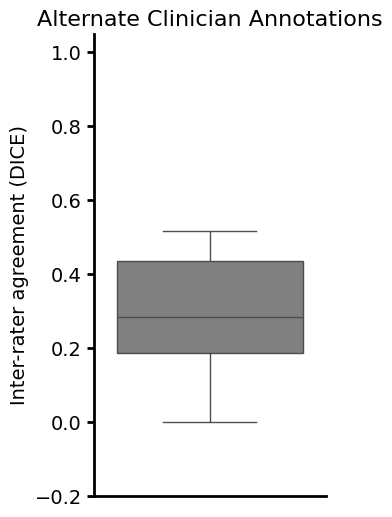

In [28]:
# all_dice = all_dice[all_dice > 0]
plt.figure(figsize=(3,6))
sns.boxplot(all_dice,color='gray')
sns.despine()
plt.title('Alternate Clinician Annotations')
plt.ylabel('Inter-rater agreement (DICE)')
plt.ylim([-.2,1.05])
plt.xticks([])

# sc.stats.mannwhitneyu(all_dice,all_plot_agreements[all_plot_agreements.model == 'LSTM'].dice),
print(sc.stats.mannwhitneyu(all_dice,pred_channels_wdice[pred_channels_wdice.model == 'LSTM'].ueo_consensus_loose_dice),
cohens_d(all_dice,pred_channels_wdice[pred_channels_wdice.model == 'LSTM'].ueo_consensus_loose_dice))